## Exoplanets

Astronomers have lots of interesting questions about planetary systems outside of our own solar system. How do they form? Are planet properties tied to the type of star that they orbit? etc. While all of these questions are worthwhile studying in their own right, they are all part of the overarching question that we all _really_ want to know the answer to: Is there alien life out there? And if so, how common is it? How common is intelligent life in the Universe?

Step one to answering these questions is to find exoplanets that look like good hosts for life. Step two would be to study their atmospheres for biosignatures--molecular abundances that could only exist in such high concentrations if they were produced by a biological process. We're currently still in step one of this search process. [The first planet orbiting a star other than our Sun was discovered in 1995](http://www.nature.com/nature/journal/v378/n6555/abs/378355a0.html) using the radial velocity method detailed in this post. We now know of at least 3500 exoplanets, with this number rapidly increasing due to multiple dedicated planet-finding surveys and missions. (Unfortunately, the vast majority of discovered exoplanets probably aren't very suitable hosts for life---see [the wiki on planetary habitability](https://en.wikipedia.org/wiki/Planetary_habitability) for a great explanation of what sorts of planets make good hosts for life.)

This notebook is an illustration of a common technique used to find exoplanets by searching for 'wobbles' in stars' radial velocity. It uses precision radial velocity data taken on the HIRES spectrometer at the Keck-I telescope, made public by the Lick-Carnegie Exoplanet Survey Team. [Here](https://home.dtm.ciw.edu/ebps/data/) is the data access webpage, and [here](http://home.dtm.ciw.edu/ebps/wp-content/uploads/2017/02/Keck_planet_search.pdf) is the published paper accompanying the dataset.


### Detecting exoplanets via Doppler spectroscopy

This method works best for finding relatively large (think Jupiter-sized) planets that are in very tight orbits around their host star (0.015 to 0.05 times the radius of Earth's orbit). We usually describe planetary systems as having all the planets orbiting a central star; this is mostly correct, but the star itself is also moving in a very small orbit about the center of mass of the entire system. If we (the observers on Earth) are viewing the star in the plane of its orbit, then we'll be able to observe a Doppler wobble effect as the star's atmosphere is slightly bluer or redder at different points in its orbit. By measuring a star's _radial velocity_ (the component of its velocity along our line of sight to it) multiple times, we can see that it is indeed moving back and forth on some orbit. The gif below provides a cartoon illustration of the Doppler wobble effect.

<div align="center">
<br>
![](files/images/spectro.gif)
*Planets and their stars orbit a common center of mass that is slightly offset from the center of the star. Credit: Emmanuel Pécontal*
<br>
</div>

After observing fluctuations in a star's radial velocity measurements, the next analysis step is to determine whether they occur at a regular frequency. You may have seen [the previous post](https://annakwa.github.io/rv-fail.html) in which I make poor data analysis choices (I tried find the best-fitting sine curve using gradient descent) and fail to find any planet signals. The much better analysis choice is to construct a periodogram and search for peaks in the power spectrum which correspond to periodicity in the data. I'll go into more detail about how this works as I analyze the data for one particular star (BD-103166) in the code below.



In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gatspy import periodic
from IPython.display import clear_output
from scipy.optimize import curve_fit
from scipy.stats import chisquare

from matplotlib import rcParams
rcParams.update({'font.size': 18})


### Go forth and find a planet 

I'll be using radial velocity data taken on the HIRES spectrometer on the Keck-I telescope. See the references at the bottom for full acknowledgements and links to the paper and dataset. I'm cheating a bit here--I picked one star for this example that I knew beforehand to host a hot Jupiter. This is so that if something goes wrong, i.e. no planet is detected, I'll know that I've made a mistake somewhere.

The figure plotted below is the raw data plotted as a function of observation time (in days since the first observation) and radial velocity. You can immediately see that the star goes back and forth between $\pm$60 m/s quite a few times in the first few hundred days of observations, which is a good sign that it probably has an orbiting companion object. However, it is hard to look at this radial velocity curve and pick out what the orbital period for this system is.

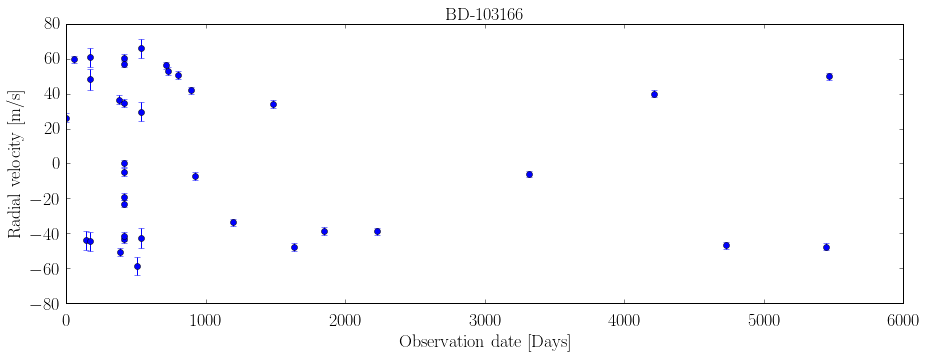

In [6]:
star_ID = 'BD-103166'

# import data for one star
# columns: Julian date, velocity [m/s], sig_vel [m/s], S_value, Halpha, median photons/pix, exposure time [s]
t, v, sig_v, sval, Halpha, phot_pix, exp_t = np.loadtxt('/home/anna/Desktop/self_teaching/blog/data/Keck_RVs/'+star_ID+'_KECK.vels', unpack=True)

# subtract off starting observation date so that first data point is t=0
start_t = np.min(t)
t = t - start_t

# plot raw, unfolded radial velocity data
fig= plt.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.errorbar(t, v, yerr=sig_v, fmt='o')

ax.set_xlabel('Observation date [Days]')
ax.set_ylabel('Radial velocity [m/s]')
ax.set_title(star_ID, fontsize=18)
#plt.savefig('RV_raw_BD-103166.png')

### The Lomb-Scargle periodogram: find a planet in four lines of code

Note that the time series data plotted above is unevenly spaced--this is common in the field of astrophysics, where an observer must have allocated telescope time and cooperative weather in order to obtain each data point. We can't interpolate between the gaps to perform a Fast Fourier Transform (FFT) on this dataset. Instead we'll perform a Least-Squares Spectral Analysis (LSSA), commonly referred to as a Lomb-Scargle analysis in deference to two big papers on this topic. This method takes a grid of frequencies spanning some range, fits a sine curve to the data for each frequency, and calculates the power at a given frequency/period (i.e. how much it contributes to the variance in the time series data). If the data is periodic, the power at the corresponding frequency value will be higher than the power at other frequencies. 

The nice thing about python is that there are many readily available modules that provide the functions that you need to perform statistical analyses. Here, I make use of the awesome [astroML](http://www.astroml.org/) module. (It also includes many other statistical and machine learning tools beyond the periodogram code used here.) The code in the following block finds and outputs the top three best-fitting periods for the time series and plots the periodogram. The best-fitting period is $\sim$3.49 days, [which agrees with the Wikipedia entry for this star](https://en.wikipedia.org/wiki/BD-10%C2%B03166).

In [7]:
# specify range of periods to search
# min, max of range comes from prior knowledge of hot Jupiter orbital periods
min_period, max_period= 0.05, 11    

# LombScargleFast implementation
model = periodic.LombScargleFast(fit_period=True,silence_warnings=True)
model.optimizer.period_range = (min_period, max_period)
model.fit(t, v, sig_v)

# Print top three periods and their power
best_periods = model.find_best_periods(3,return_scores=True)
clear_output()
print('Best-fitting periods:')
print('P=',best_periods[0][0], ' days , power=',best_periods[1][0])
print('P=',best_periods[0][1], ' days , power=',best_periods[1][1])
print('P=',best_periods[0][2], ' days , power=',best_periods[1][2])



Best-fitting periods:
P= 3.48793213695  days , power= 0.983500921204
P= 0.775519044909  days , power= 0.74351492656
P= 1.39653704756  days , power= 0.736981155036


#### Frequency spacing is important when using periodograms to find periodic signals!


One thing to be careful of when searching for periodicity with this method is that you need to search over a sufficiently fine grid of frequencies. If your spacing between frequencies is too large, you can easily miss the peak that corresponds to the underlying period in your data. 

I plot two periodograms for the same dataset below. The periodogram on the left uses a higher-resolution frequency grid that is able to resolve and find the peak corresponding to the correct period at ~3.5 days. On the right is a periodogram constructed using a frequency grid that is too coarse and misses the peak. 

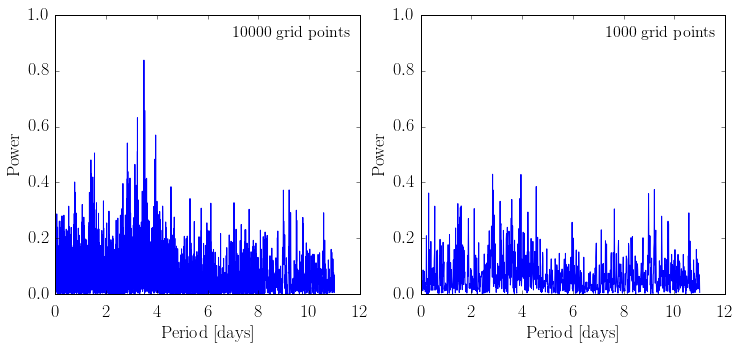

In [8]:
# Plot the periodogram to see peaks at periods. Left is 

p_arr = np.linspace(min_period, max_period, 10000)
power = model.score(p_arr)

fig= plt.figure(figsize=(12,5))

ax=fig.add_subplot(121)
ax.plot(p_arr, power)
ax.set_xlabel('Period [days]')
ax.set_ylabel('Power')
ax.set_ylim([0,1])
ax.annotate('10000 grid points',
            xy=(0.97,0.92),
            backgroundcolor='white',
            xycoords='axes fraction',
            horizontalalignment='right',
            size=16)

p_arr = np.linspace(min_period, max_period, 1000)
power = model.score(p_arr)

ax=fig.add_subplot(122)
ax.plot(p_arr, power)
ax.set_xlabel('Period [days]')
ax.set_ylabel('Power')
ax.set_ylim([0,1])
ax.annotate('1000 grid points',
            xy=(0.97,0.92),
            backgroundcolor='white',
            xycoords='axes fraction',
            horizontalalignment='right',
            size=16)


plt.show()

Now for the 'money plot' that really makes the planet signal visually evident. Now that I know what the orbital period of the planet is ($\sim$3.5 days), I can use the observation time of each data point to calculate its orbital phase (*phase* = *observation time* modulo *period*). Then I plot the radial velocity curve again, but this time the x-axis is the phase of each observation instead of the observation time. This plot is called the 'phase-folded' radial velocity curve.

I'll also fit a sine curve to the phase-folded data, where the free parameters are the amplitude, phase shift, and y-axis offset. The amplitude tells us how strongly the star is tugged upon by its planet companion. (In the next post I'll go into more detail on how we can use the amplitude and period to learn about the planet.)

I also plot the phase-folded curves for the second and third highest periods detected in the data. If there were additional planets in the system that were also tugging on the star, they might also show up in the data as peaks in the periodogram. There are other systematics that might produce these peaks; however., I definitely don't know enough about those uncertainties to say more about them right now. I just plotted the data at these periods to see what the lower-powered periodicities looked like.

In [14]:
# Given fixed period, phase fold the data and then fit amplitude and phase shift
# Calcuate chi-squared and have some cutoff at which we call a detection of periodicity significant

def sine_model(x, amp, ph):
    # fixed freq b/c fitting phase folded data: x ranges from 0-1
    return amp*np.sin(x * 2.*np.pi + ph) 

def chi2dof(x, y_obs, y_model, sigma):
    sum=0.
    dof=len(x)-1
    for i in range(len(x)):
        sum+= (y_obs[i]-y_model[i])**2/y_model[i]**2
    return sum/dof

def fit2sine(raw_t, raw_v, P):
    # returns chi2 stat, best-fitting amplitude A and phase c for sine fit to phase-folded data 
    # raw_t, raw_v are the observation dates (adjusted so first obs is at t=0 days) and velocities
    N_obs = len(raw_t)
    phase = []
    for i in range(N_obs):
        phase_folded_t = t[i]%P
        phase.append(phase_folded_t/P)
    guess_amplitude = 0.5*( abs(np.max(raw_v)) + abs(np.min(raw_v)) )
    guess_phase = 0.3*np.pi
    initial_guesses = [guess_amplitude, guess_phase]
    fit = curve_fit(sine_model, phase, raw_v, p0=initial_guesses)
    A, c = fit[0][0], fit[0][1]
    chi2 = chi2dof(t, v, sine_model(np.array(phase),A,c), sig_v)
    return (A, c, chi2)


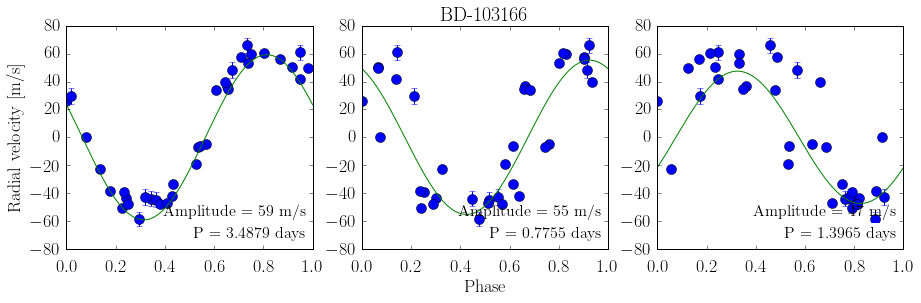

In [15]:
# plot for top three best-fitting periods
period_arr = [best_periods[0][0],best_periods[0][1],best_periods[0][2]]
phase_arr = [[], [], []]

for j in range(3):
    for i in range(len(t)):
        phase_folded_t = t[i]%period_arr[j]
        phase_arr[j].append(phase_folded_t/period_arr[j])
        
fig= plt.figure(figsize=(15,4))
x_arr=np.linspace(0,1,200)

for p in [0,1,2]:
    ax=fig.add_subplot(1,3,p+1)
    P = period_arr[p]
    ax.errorbar(phase_arr[p], v, yerr=sig_v, fmt='o', markersize=10)
    sinefit = fit2sine(t, v, P)
    A, c = sinefit[0], sinefit[1]
    fit_curve = sine_model(np.array(x_arr), A, c)
    ax.plot(x_arr, fit_curve)
    ax.annotate('P = '+"%.4f" % P+' days',
                xy=(0.97,0.05),
                backgroundcolor='white',
                xycoords='axes fraction',
                horizontalalignment='right',
                size=16)
    ax.annotate('Amplitude = '+"%.0f" % A+' m/s',
            xy=(0.97,0.15),
            #backgroundcolor='white',
            xycoords='axes fraction',
            horizontalalignment='right',
            size=16)
    if p==0:
        ax.set_ylabel('Radial velocity [m/s]')
    if p==1:
        ax.set_title('BD-103166', fontsize=20)
        ax.set_xlabel('Phase')

plt.show()
    


That's it for this post! In the next post I'll wrap up the exoplanet analysis by writing a simple data analysis pipeline, running all 1699 stars in the public dataset through the pipeline, and determining the prevalence and characteristics of hot Jupiters in the dataset.



### References

* The precision radial velocity data used here was taken on the HIRES spectrometer at the Keck-I telescope, made public by the Lick-Carnegie Exoplanet Survey Team. [Here](https://home.dtm.ciw.edu/ebps/data/) is the data access webpage, and [here](http://home.dtm.ciw.edu/ebps/wp-content/uploads/2017/02/Keck_planet_search.pdf) is the published paper accompanying the dataset.

* Lots of credit to [this writeup by Jake VanderPlas](http://www.astroml.org/gatspy/periodic/lomb_scargle.html) which gives a nice, clear explanation of Lomb Scargle periodogram algorithms and how to apply them to unevenly sampled astrophysical data. I make use of his [gatspy](http://www.astroml.org/gatspy/) package of time series analysis tools (part of the [astroML](http://www.astroml.org) module).

* For more details on radial velocity fitting and exoplanet searches, see the [Exoplanet Musings](https://exoplanetmusings.wordpress.com) blog. It's no longer updated but has tons of great posts.